loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Epoch 1/150:   0%|          | 0/32 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([2, 1, 1, 2], device='cuda:0'), tensor([2, 1, 2, 1], device='cuda:0'), tensor([1, 1, 2], device='cuda:0'), tensor([1], device='cuda:0'), tensor([2, 1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([2, 1, 2], device='cuda:0'), tensor([2, 2, 1, 1], device='cuda:0'), tensor([1], device='cuda:0'), tensor([2, 1], device='cuda:0'), tensor([2], device='cuda:0'), tensor([1, 2], device='cuda:0'), tensor([2], device='cuda:0'), tensor([1], device='cuda:0'), tensor([1, 1, 1, 2], device='cuda:0'), tensor([2], device='cuda:0')]


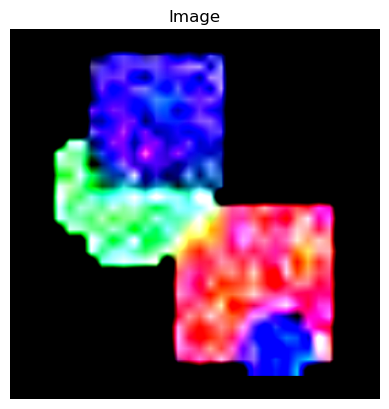

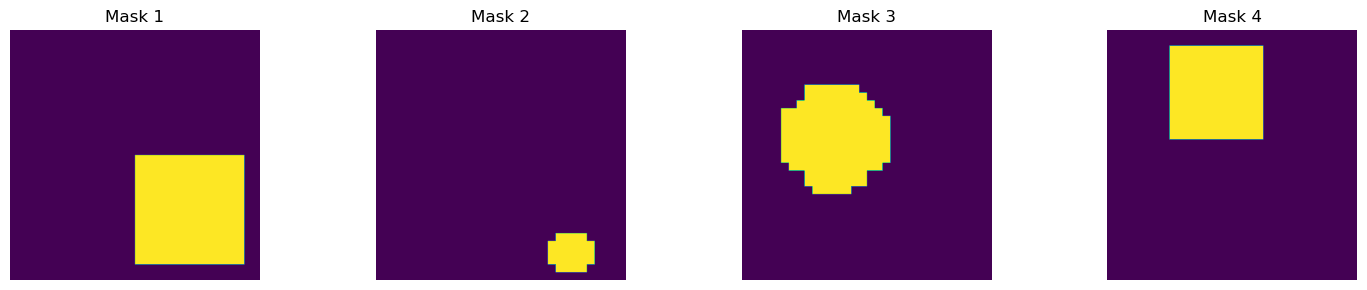

Epoch 1/150:   0%|          | 0/32 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 6.56 MiB is free. Including non-PyTorch memory, this process has 3.79 GiB memory in use. Of the allocated memory 3.27 GiB is allocated by PyTorch, and 438.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [4]:
from data.config import cfg, process_funcs_dict
from data.coco import CocoDataset
from data.loader import build_dataloader
from modules.solov2 import SOLOV2
import torch.optim as optim
import torch
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def set_lr(optimizer, new_lr):
    """Set learning rate for all parameter groups."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def gradinator(x):
    """Disable gradient calculation for tensor."""
    x.requires_grad = False
    return x

def build_process_pipeline(pipeline_config):
    """Build data processing pipeline from config."""
    assert isinstance(pipeline_config, list)
    process_pipelines = []
    for pipconfig in pipeline_config:
        assert isinstance(pipconfig, dict) and 'type' in pipconfig
        args = pipconfig.copy()
        obj_type = args.pop('type')
        if isinstance(obj_type, str):
            process_pipelines.append(process_funcs_dict[obj_type](**args))
    return process_pipelines

def get_warmup_lr(cur_iters, warmup_iters, base_lr, warmup_ratio):
    """Calculate learning rate during warmup period.""" #? Linear works for now.
    k = (1 - cur_iters / warmup_iters) * (1 - warmup_ratio)
    warmup_lr = base_lr * (1 - k)
    return warmup_lr

def train(epoch_iters=1, total_epochs=36):
    """Main training function."""
    # Build data pipeline
    transforms_pipelines = build_process_pipeline(cfg.train_config.train_pipeline)
    
    # Build dataset
    dataset = CocoDataset(ann_file=cfg.dataset.train_info,
                          pipeline=transforms_pipelines,
                          img_prefix=cfg.dataset.trainimg_prefix,
                          data_root=cfg.dataset.train_prefix)
    
    # Load dataset
    data_loader = build_dataloader(
        dataset, 
        cfg.train_config.imgs_per_gpu, 
        cfg.train_config.workers_per_gpu, 
        num_gpus=cfg.train_config.num_gpus, 
        shuffle=True
    )
    
    # Initialize model
    model = SOLOV2(cfg, pretrained=None, mode='train')
    # Always start with iteration 0
    total_iterations_completed = 0
    
    model = model.cuda()
    model.train()
    
    # Configure optimizer
    optimizer_config = cfg.train_config.optimizer
    optimizer = optim.SGD(
        model.parameters(), 
        lr=optimizer_config['lr'], 
        momentum=optimizer_config['momentum'], 
        weight_decay=optimizer_config['weight_decay']
    )
    
    # Calculate remaining iterations
    base_loop = epoch_iters
    left_loops = total_epochs - base_loop + 1
    
    # Training loop
    for epoch in range(left_loops):
        current_epoch = epoch + base_loop
        
        # Initialize metrics
        running_loss = 0.0
        running_loss_ins = 0.0
        running_loss_cate = 0.0
        
        # Create progress bar for epoch
        pbar = tqdm(data_loader, total=len(data_loader), 
                    desc=f"Epoch {current_epoch}/{total_epochs}")
        
        # Batch iteration
        for i, data in enumerate(pbar):
            current_iteration = total_iterations_completed + i + 1
            
            # Always apply warmup
            warm_lr = get_warmup_lr(
                current_iteration, 
                cfg.train_config.lr_config['warmup_iters'],
                optimizer_config['lr'], 
                cfg.train_config.lr_config['warmup_ratio'],
            )
            set_lr(optimizer, warm_lr)
            current_lr = warm_lr
            
            # Prepare input data
            imgs = gradinator(data['img'].data[0].cuda())
            img_meta = data['img_metas'].data[0]
            
            gt_bboxes = []
            for bbox in data['gt_bboxes'].data[0]:
                bbox = gradinator(bbox.cuda())
                gt_bboxes.append(bbox)
            
            gt_masks = data['gt_masks'].data[0]
            
            gt_labels = []
            for label in data['gt_labels'].data[0]:
                label = gradinator(label.cuda())
                gt_labels.append(label)
            
            # print the labels for the first image
            if i == 0:
                print(gt_labels)

            # Display the first image (remove in production)
            if i == 0:
                plt.imshow(imgs[0].cpu().numpy().transpose(1, 2, 0))
                plt.title("Image")
                plt.axis('off')
                plt.show()
            
            # Display masks (remove in production)
            num_masks, _, _ = gt_masks[0].shape
            # Display masks horizontally (remove in production)
            if i == 0 and num_masks > 0:  # Only for the first batch
                fig, axs = plt.subplots(1, min(num_masks, 5), figsize=(15, 3))
                for j in range(min(num_masks, 5)):
                    if num_masks == 1:
                        axs.imshow(gt_masks[0][j])
                        axs.set_title(f"Mask {j+1}")
                        axs.axis('off')
                    else:
                        axs[j].imshow(gt_masks[0][j])
                        axs[j].set_title(f"Mask {j+1}")
                        axs[j].axis('off')
                plt.tight_layout()
                plt.show()

            # Forward pass
            loss = model.forward(
                img=imgs,
                img_meta=img_meta,
                gt_bboxes=gt_bboxes,
                gt_labels=gt_labels,
                gt_masks=gt_masks
            )

            # Calculate total loss
            losses = loss['loss_ins'] + loss['loss_cate']
            
            # Update running metrics
            running_loss += losses.cpu().item()
            running_loss_ins += loss['loss_ins'].cpu().item()
            running_loss_cate += loss['loss_cate'].cpu().item()
            
            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            
            # Update weights if loss is finite
            if torch.isfinite(losses).item():
                optimizer.step()
            else:
                raise RuntimeError("Loss is not finite! Cannot backpropagate.")
            
            # Update progress bar with current losses
            batch_count = i + 1
            pbar.set_postfix({
                'loss': running_loss / batch_count,
                'loss_ins': running_loss_ins / batch_count,
                'loss_cate': running_loss_cate / batch_count,
                'lr': current_lr
            })
        
        # Update total iterations after each epoch
        total_iterations_completed += len(data_loader)
        
        # Save model after each epoch
        save_name = f"./weights/solov2_{cfg.backbone.name}_epoch_{current_epoch}.pth"
        model.save_weights(save_name)

if __name__ == '__main__':
    train(epoch_iters=cfg.train_config.epoch_iters_start, total_epochs=150)